# Neural network regression

In this many-to-one regression setup, we stack the series from all inverters into a long vector and try to predict the aggregate power a few steps ahead.

## Training

In [5]:
import core.preprocessing as pp
from core.neural_net_forecaster import NeuralNetForecaster

dm = pp.DataManager()
dm.load_all_and_split(kind='small')
dftrain = dm.detrended_train
dfdev = dm.detrended_dev

# Drop columns zeroed out by detrend transformation
for item in pp.DROP_LIST:
    key = 'S{:02}'.format(item)
    del dftrain[key]
    del dfdev[key]

problem = NeuralNetForecaster(dftrain, dfdev, arch='FC', nepochs=500, rmlogdir=True)

problem.make_forecasts()

Done with batch 1
Done with batch 101
Done with batch 201
Done with batch 301
Done with batch 401


## Prediction

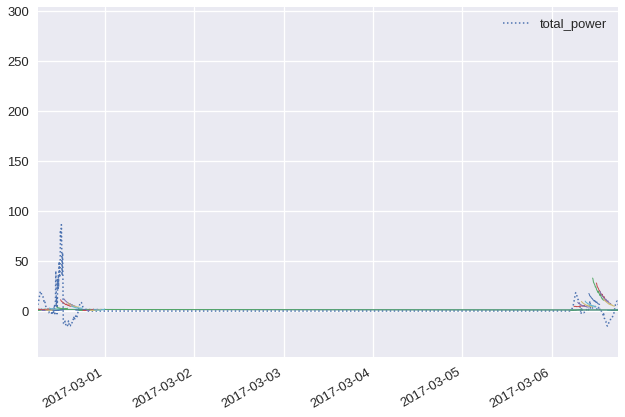

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk')

problem.plot_test()

ax = plt.gca()
lim = ax.get_xlim()
chunk = (lim[1] - lim[0])/8.
start = lim[0] + 2*chunk
end = lim[0] + 6*chunk

ax.set_xlim(start, end)

plt.show()

In [8]:
problem.calc_mse()

3370.9245911930793